In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow import random
import joblib
import pandas as pd

In [37]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
cifar_classes = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

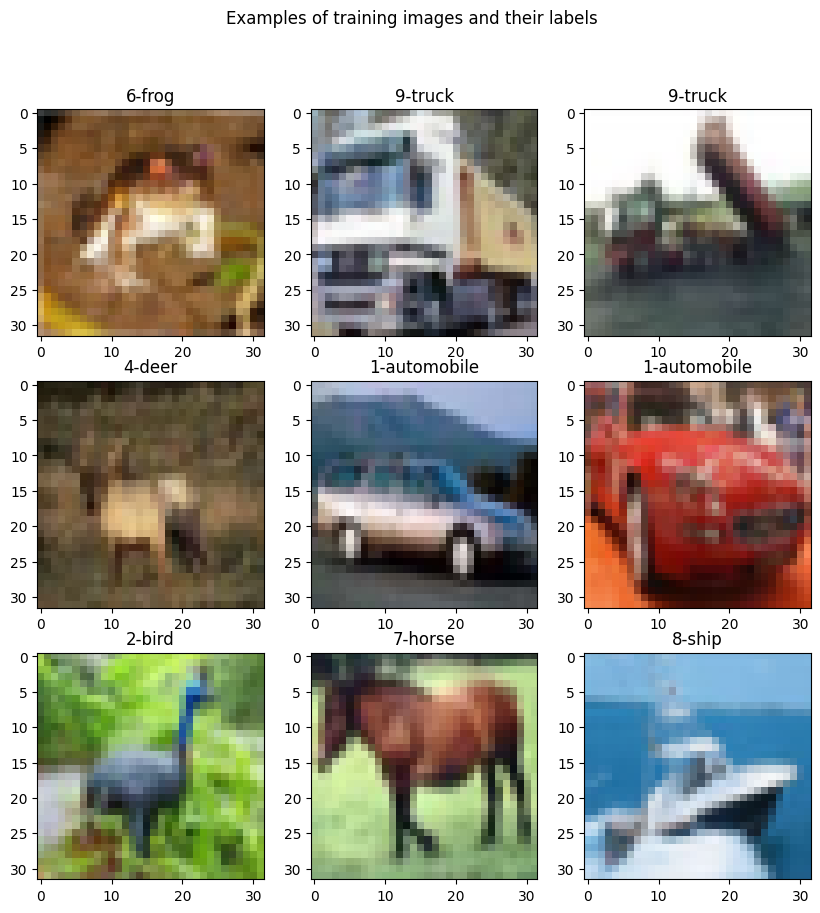

In [38]:
# Display examples of training images and their labels
plt.figure(figsize=(10, 10))
plt.suptitle('Examples of training images and their labels')
for i in range(9):
    plt.subplot(331 + i, title=f'{y_train[i, 0]}-{cifar_classes[y_train[i, 0]]}')
    plt.imshow(X_train[i])
plt.show()

In [39]:
# Preprocess data
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(f"Shape of training data:\nX-train_shape={X_train.shape}, y-train_shape={y_train.shape}")
print(f"Shape of testing data:\nX-test_shape={X_test.shape}, y-test_shape={y_test.shape}")

Shape of training data:
X-train_shape=(50000, 32, 32, 3), y-train_shape=(50000, 10)
Shape of testing data:
X-test_shape=(10000, 32, 32, 3), y-test_shape=(10000, 10)


In [40]:
# Define the CNN model
def get_model():
    model = Sequential()
    model.add(Conv2D(25, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(50, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(70, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [41]:
# Set random seed and get the model
random.set_seed(0)
model = get_model()
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 25)     │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 50)     │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16, 16, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 70)     │        31,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 70)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8, 8, 70)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 500)            │     2,240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         2,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,830 (9.20 MB)

 Trainable params: 2,411,830 (9.20 MB)

 Non-trainable params: 0 (0.00 B)

None


In [42]:
# Define callbacks
checkpoint = ModelCheckpoint("./models/cifar10_epo_cnn.keras", monitor='val_accuracy', mode='max', save_best_only=True)
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, mode="max")
callbacks = [early_stop, checkpoint]

In [43]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=True, validation_split=0.2, callbacks=callbacks)
model.save("./models/cifar10_epo_cnn.keras")
joblib.dump(history.history, "./models/cifar10_epo_cnn.history")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - accuracy: 0.3293 - loss: 1.8075 - val_accuracy: 0.5761 - val_loss: 1.1850
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.5669 - loss: 1.2060 - val_accuracy: 0.6678 - val_loss: 0.9508
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.6376 - loss: 1.0221 - val_accuracy: 0.6985 - val_loss: 0.8550
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.6824 - loss: 0.9039 - val_accuracy: 0.7165 - val_loss: 0.8118
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.7062 - loss: 0.8362 - val_accuracy: 0.7273 - val_loss: 0.7902
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.7296 - loss: 0.7686 - val_accuracy: 0.7382 - val_loss: 0.7585
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.7447 - loss: 0.7192 - val_accuracy: 0.7373 - val_loss: 0.7522
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.7603 -

['./models/cifar10_epo_cnn.history']

In [44]:
# Load the model and its history
from keras.models import load_model
model = load_model('./models/cifar10_epo_cnn.keras')
history = joblib.load("./models/cifar10_epo_cnn.history")

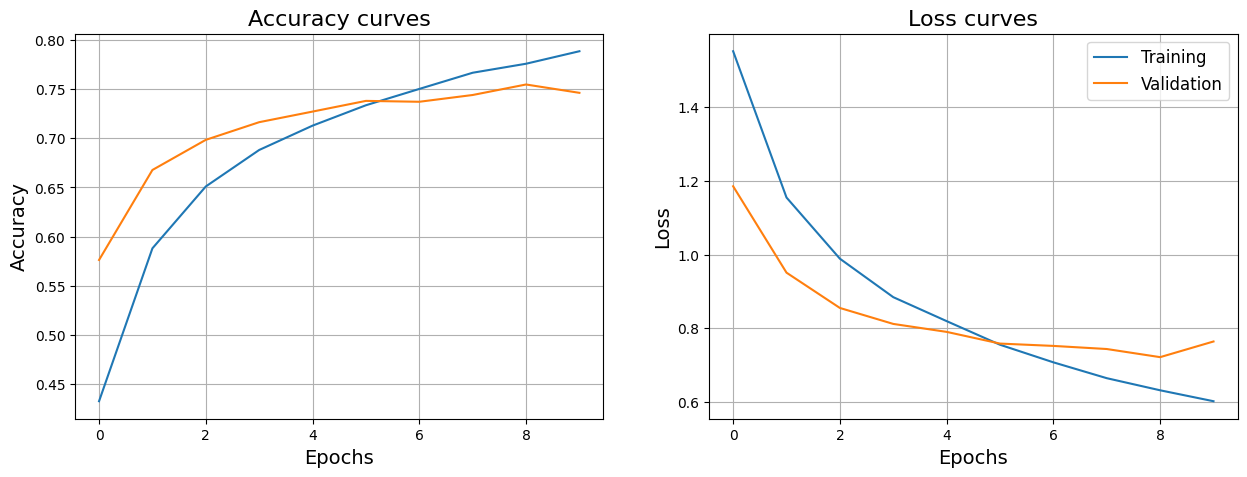

In [45]:
# Plot accuracy and loss curves
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history['accuracy'], 'C0')
ax[0].plot(history['val_accuracy'], 'C1')
ax[0].set_title(label="Accuracy curves", fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=14)
ax[0].grid()

ax[1].plot(history['loss'], 'C0')
ax[1].plot(history['val_loss'], 'C1')
ax[1].set_title(label="Loss curves", fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Loss', fontsize=14)
ax[1].grid()
plt.legend(['Training', 'Validation'], fontsize=12)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


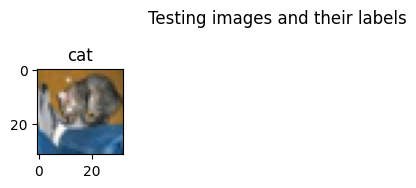

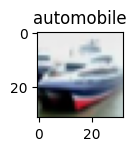

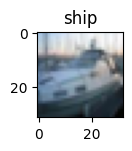

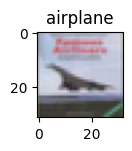

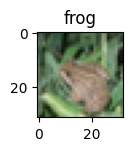

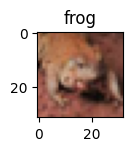

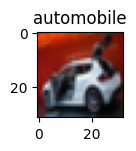

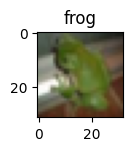

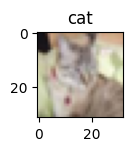

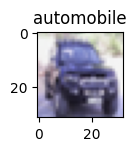

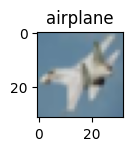

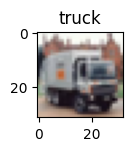

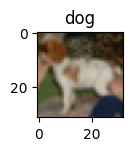

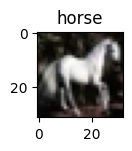

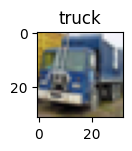

,class name,count
0,airplane,2
1,automobile,3
2,cat,0
3,dog,2
4,frog,0
5,horse,1
6,ship,3
7,truck,1


In [48]:
# Predict and display test images
m = 15
y_pred = model.predict(X_test[:m])
y_pred_class = y_pred.argmax(-1)
plt.suptitle('Testing images and their labels')
for i in range(15):
    plt.subplot(3, 5, i + 1, title=f'{cifar_classes[y_pred_class[i]]}')
    plt.imshow(X_test[i])
    plt.show()
freq = list(zip(cifar_classes[np.unique(y_pred_class)], np.bincount(y_pred_class)))
pd.DataFrame(freq, columns=["class name", "count"])